# 时间序列分析之VAR
## 理论概述
### introdution
> fork from [Python实现向量自回归（VAR）模型——完整步骤](https://blog.csdn.net/mooncrystal123/article/details/86736397)

以金融价格为例，传统的时间序列模型比如ARIMA,ARIMA-GARCH等，只分析价格自身的变化，模型的形式为：
$$ y_t=\beta _1\cdot y_{t-1}+\beta _2\cdot y_{t-2}+...$$
其中$y_{t-1}$为自身滞后项

但是VAR模型除了分析自身滞后项的影响外，还分析其他相关因素的滞后项对未来值产生的影响，模型的形式为：
$$ y_t=\beta _1\cdot y_{t-1}+\alpha _1\cdot x_{t-1}+\beta _2\cdot y_{t-2}+...$$
其中$x_{t-1}$就是其他因子的滞后项。

总结一下，就是可以把VAR模型看做是集合多元线性回归的优点（可以加入多个因子）以及时间序列模型的优点（可以分析滞后项的影响）的综合模型。

VAR其实是一类模型，以上是最基础的VAR模型形式，<font color=red>其他还有SVAR,CVAR,VECM，同统称为VAR类模型。</font>

### Modeling Steps
这种数学模型都有固定的建模步骤：

1）**画N个因子的序列相关图，**计算相关系数 correlation coiffiant，查看一下线性相关度。（相关系数大小只反映线性相关程度，不反应非线性相关，如果等于0，不能排除存在非线性相关的可能。）

**2）对N个因子的原始数据进行平稳性检验，也就是ADF检验。**

VAR模型要求所有因子数据同阶协整，也就是N个因子里面如果有一个因子数据不平稳，就要全体做差分，一直到平稳为止。

**3）对应变量（yt）和影响因子（Xt）做协整检验**

一般就是EG协整关系检验了，为了看看Y和各个因子Xi之间是否存在长期平稳的关系，这个检验要放在所有数据都通过ADF检验以后才可以做。如果那个因子通不过协整检验，那基本就要剔除了。

**4）然后就是通过AIC,BIC,以及LR定阶。**

一般来说是综合判断三者。AIC,BIC要最小的，比如-10的AIC就优于-1AIC，LR反之要最大的。但是具体偏重那个，就看个人偏好，一般来说，博主的经验是看AIC和LR，因为BIC的惩罚力度大于AIC，大多数时间不太好用。

具体的实现步骤一般是，把滞后项的阶数列一个范围，比如1-5，然后直接建模，其他啥都不看，先看AIC,BIC,LR的值。一般符合条件的不会只有一个，可以挑2-3个最好的，继续进行。

**5）定阶完成后，就是估计参数，看参数的显著性。**

好的模型所有参数的要通过显著性检验。

**6）对参数进行稳定性检验**

VAR除了对原始数据要进行平稳处理，估计出来的参数还需要检验参数稳定性。

这是为了查看模型在拟合时，数据样本有没有发生结构性变化。

有两张检验方法，这两种方法的基本概念是：

第一个是：AR根，VAR模型特征方程根的绝对值的倒数要在单位圆里面。

第二个是：cusum检验，**模型残差累积和**在一个区间内波动，不超出区间。

这里要注意的是CUSUM检验的原价设(H0)：系数平稳，备择假设才是不平稳。所以CUSUM结果要无法拒绝原假设才算通过。<font color=red>只有通过参数稳定性检验的模型才具有预测能力,进行脉冲响应和方法分解分析才有意义。</font>

**7）使用乔里斯基正交化残差进行脉冲响应分析**

举例：要分析和预测的是Y，影响Y的有两个因子X1，X2。

脉冲响应是1对1，根据以上条件，就要做两个脉冲响应分析,分别是：Y和X1，Y和X2。

看看不同因子上升或者下降，对Y的冲击的程度和方式（Y上升还是下降），以及持续时间。

**8）使用乔里斯基正交化残差进行方差分解分析**

举例：要分析和预测的是Y，影响Y的有两个因子X1，X2。

方差分解是1对1，根据以上条件，就要做两个方差分解分析,分别是：Y和X1，Y和X2。

**9）为什么使用乔里斯基正交化残差？**

因为进行方差分解和脉冲响应分析的时候，要求模型的残差为白噪声。但是！现实中，我们很难把所有影响Y的因素都囊括进方程，这就导致，现实中VAR模型的残差一般都不是白噪声。因此使用乔里斯基正交化来处理模型的残差。

VAR建模的时候以上面的条件为例，其实模型估计参数时会给出三个3个方程(应变量各自不同）：

方程1：$y_t=\beta_1\cdot y_{t-1} + \alpha_1 \cdot X1_{t-1} + \Theta _1\codt X2_{t-1} + \varepsilon _t$

方程2：$X1_t=\beta_1\cdot X1_{t-1}+ \alpha_1\cdot y_{t-1} +\Theta _1\cdot X2_{t-1}+ \eta _t$

方程3：$X2_t=\beta_1\cdot X2_{t-1}+ \alpha_1\cdot y_{t-1} +\Theta _1\cdot X1_{t-1}+ \omega _t$

方程1的残差序列：$\varepsilon _t$

方程2的残差序列：$\eta _t$

方差3的残差序列：$\omega _t$

<font color=#2894FF>**三个方程的乔里斯基正交化的步骤就是：**</font>

正交1：$\frac{\eta _t}{\varepsilon _t}$

正交2：$\frac{\omega _{t}}{\varepsilon _{t}}$

正交3：$\frac{\omega _{t}}{\eta _{t}}$

正交4：$\frac{\frac{\eta _{t}}{\varepsilon _{t}}}{\frac{\omega _{t}}{\varepsilon _{t}}}$

正交5：$\frac{\frac{\eta _{t}}{\varepsilon _{t}}}{\frac{\omega _{t}}{\eta _{t}}}$

最后用正交4/正交5，得到的序列就是乔里斯基正交化残差了。

**乔里斯基正交化之前要对方程的变量按重要性排序，更重要的放在分子上。**

## python实现(基于statsmodel)

### 导入模块

In [1]:
# 模型相关包
import statsmodels.api as sm
import statsmodels.stats.diagnostic
# 画图包
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
# 其他包
import pandas as pd
import numpy as np

### 画序列相关图
序列相关图是指因子之间的相关系数图，这里我考虑利用某一个县8年海洛因数据，周边三个县作为其他因子

In [2]:
excel_origin=pd.ExcelFile('MCM_NFLIS_Data.xlsx')# 原始数据
data_origin=pd.read_excel(excel_origin,'Data')
data_Heroin=data_origin[data_origin['SubstanceName']=='Heroin']
data_Heroin

,YYYY,State,COUNTY,FIPS_State,FIPS_County,FIPS_Combined,SubstanceName,DrugReports,TotalDrugReportsCounty,TotalDrugReportsState
3,2010,VA,ALEXANDRIA CITY,51,510,51510,Heroin,5,427,41462
7,2010,VA,AMELIA,51,7,51007,Heroin,1,94,41462
8,2010,VA,ARLINGTON,51,13,51013,Heroin,41,610,41462
14,2010,OH,ATHENS,39,9,39009,Heroin,72,664,70999
16,2010,OH,AUGLAIZE,39,11,39011,Heroin,35,184,70999
...,...,...,...,...,...,...,...,...,...,...
23981,2017,OH,ROSS,39,141,39141,Heroin,67,608,119349
24008,2017,VA,STAUNTON CITY,51,790,51790,Heroin,1,10,36994
24030,2017,VA,WARREN,51,187,51187,Heroin,73,443,36994
24056,2017,PA,WYOMING,42,131,42131,Heroin,20,114,68751


用dataprocession中处理过的数据，我们将armstrong作为主要回归对象，它周围有六个county，见下图
![](https://s2.ax1x.com/2020/02/25/3JzgN8.png)

现在得到2010-2017年这7个县的海洛因数据

In [3]:
#pre 限制为PA州
data_Heroin=data_Heroin[data_Heroin['State']=='PA']

# armstrong
armstrong=data_Heroin[data_Heroin['COUNTY']=='ARMSTRONG']
# allegheny
allegheny=data_Heroin[data_Heroin['COUNTY']=='ALLEGHENY']
# westmoreland
westmoreland=data_Heroin[data_Heroin['COUNTY']=='WESTMORELAND']
# indiana 
indiana =data_Heroin[data_Heroin['COUNTY']=='INDIANA']
# jefferson
jefferson=data_Heroin[data_Heroin['COUNTY']=='JEFFERSON']
# clarion
clarion=data_Heroin[data_Heroin['COUNTY']=='CLARION']
#butler
butler=data_Heroin[data_Heroin['COUNTY']=='BUTLER']

In [4]:
# 先只取两个
data_nearby=pd.DataFrame(index=np.arange(2010,2018))
data_nearby['armstrong']=list(armstrong['DrugReports'])
data_nearby['allegheny']=list(allegheny['DrugReports'])
data_nearby['jefferson']=list(jefferson['DrugReports'])
data_nearby

,armstrong,allegheny,jefferson
2010,96,2592,47
2011,86,2298,56
2012,65,2739,36
2013,57,3279,26
2014,151,3774,30
2015,113,3674,15
2016,119,3400,12
2017,34,1894,11


In [5]:
def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[np.random.randint(0,14)]
    return "#"+color

In [6]:
output_notebook() #导入这个命令之后bokeh的绘画内容都在notebook上显示
p=figure(plot_width=800, plot_height=400)
p.line(data_nearby.index,data_nearby['armstrong'],line_color=randomcolor(),legend='armstrong')
p.line(data_nearby.index,data_nearby['allegheny'],line_color=randomcolor(),legend='allegheny')
p.line(data_nearby.index,data_nearby['jefferson'],line_color=randomcolor(),legend='jefferson')
show(p)

Loading BokehJS ...

E:\anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


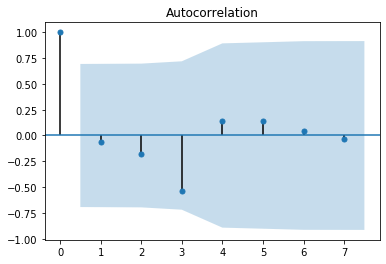

In [7]:
# 自相关
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_nearby['armstrong']).show()

### ADF单位根平稳性检验

In [8]:
sm.tsa.stattools.adfuller(data_nearby['armstrong'],maxlag=1,regression ='c',autolag ='AIC',store = False,regresults = False)

(-1.9733846253036527,
 0.2983635360190785,
 0,
 7,
 {'1%': -4.9386902332361515,
  '5%': -3.477582857142857,
  '10%': -2.8438679591836733},
 65.46510007042656)

**Returns:**

- **adffloat  ADF的float形式**

The test statistic.

- **pvaluefloat  近似p值**

MacKinnon’s approximate p-value based on MacKinnon (1994, 2010).

- **usedlagint  使用的滞后项**

The number of lags used.

- **nobsint**

The number of observations used for the ADF regression and calculation of the critical values.

- **critical valuesdict**

Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).

- **icbestfloat**

The maximized information criterion if autolag is not None.

- **resstoreResultStore, optional**

A dummy class with results attached as attributes.

**何确定该序列能否平稳呢？主要看：**

- 1%、%5、%10不同程度拒绝原假设的统计值和<font color=red>ADF Test result</font>的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设。

- P-value是否非常接近0

ADF检验的原假设是存在单位根，只要这个统计值是小于1%水平下的数字就可以极显著的拒绝原假设，认为数据平稳。注意，ADF值一般是负的，也有正的，但是它只有小于1%水平下的才能认为是及其显著的拒绝原假设。对于ADF结果在1% 以上 5%以下的结果，也不能说不平稳，关键看检验要求是什么样子的。

比如上面这个数据，得到的结果是
```
(-1.9733846253036527,
 0.2983635360190785,
 0,
 7,
 {'1%': -4.9386902332361515,
  '5%': -3.477582857142857,
  '10%': -2.8438679591836733},
 65.46510007042656)
 ```
 
 ADF Test result的值(-1.973)大于1%、%5、%10不同程度拒绝原假设的统计值（注意是负数）,而且p-value也不太接近0，所以我们要差分处理

## 上面的数据太少了算了换一个官网例子

In [9]:
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import pandas as pd
mdata = sm.datasets.macrodata.load_pandas().data

In [10]:
mdata

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [11]:
# prepare dates index 准备日期索引
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]

# 导入statsmodels中的日期工具
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)


In [12]:
mdata = mdata[['realgdp','realcons','realinv']]
mdata

,realgdp,realcons,realinv
0,2710.349,1707.4,286.898
1,2778.801,1733.7,310.859
2,2775.488,1751.8,289.226
3,2785.204,1753.7,299.356
4,2847.699,1770.5,331.722
...,...,...,...
198,13324.600,9267.7,1990.693
199,13141.920,9195.3,1857.661
200,12925.410,9209.2,1558.494
201,12901.504,9189.0,1456.678


In [13]:
mdata.index = pd.DatetimeIndex(quarterly)
data = mdata.diff().dropna()

In [14]:
data

,realgdp,realcons,realinv
1959-06-30,68.452,26.3,23.961
1959-09-30,-3.313,18.1,-21.633
1959-12-31,9.716,1.9,10.130
1960-03-31,62.495,16.8,32.366
1960-06-30,-13.309,22.4,-33.570
...,...,...,...
2008-09-30,-90.666,-83.3,-35.825
2008-12-31,-182.680,-72.4,-133.032
2009-03-31,-216.510,13.9,-299.167
2009-06-30,-23.906,-20.2,-101.816


E:\anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


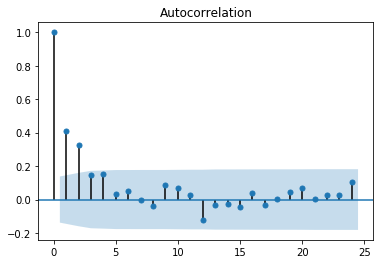

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['realgdp']).show()

In [16]:
dataf=statsmodels.tsa.stattools.adfuller(data['realgdp'],maxlag=None)# 平稳性已经很高了

In [17]:
model = VAR(data)
results = model.fit(2)
results.summary()

E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Mar, 2020
Time:                     16:48:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    20.5675
Nobs:                     200.000    HQIC:                   20.3614
Log likelihood:          -2852.49    FPE:                6.05346e+08
AIC:                      20.2212    Det(Omega_mle):     5.45987e+08
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              10.308143         6.425207            1.604           0.109
L1.realgdp         -0.394370         0.148481           -2.656           0.008
L1.realcons         1.185980         0.186610            6.355    